# Looking at TCR data in all-cells object to mark non-T cells with BCR information as doublets

CVID, revisions

analysis with scirpy

In [1]:
import scirpy as ir # requires 'pip install scirpy'
import scanpy as sc
from glob import glob
import pandas as pd
import numpy as np
import tarfile
import anndata
import warnings
from numba import NumbaPerformanceWarning

# ignore numba performance warnings
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

In [2]:
sc.settings.set_figure_params(dpi=100)


In [3]:
%%bash

pip freeze

aiohttp @ file:///home/conda/feedstock_root/build_artifacts/aiohttp_1605734406386/work
airr==1.3.1
alabaster==0.7.12
alembic @ file:///home/conda/feedstock_root/build_artifacts/alembic_1599849174714/work
anndata @ file:///home/conda/feedstock_root/build_artifacts/anndata_1605539061264/work
annoy @ file:///home/conda/feedstock_root/build_artifacts/python-annoy_1602559349681/work
arboreto==0.1.5
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1602546592129/work
async-generator==1.10
async-timeout==3.0.1
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1599308529326/work
Babel @ file:///home/conda/feedstock_root/build_artifacts/babel_1605182336601/work
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache==1.6.1
bbknn==1.3.12
bleach @ file:///home/conda/feedstock_root/build_artifacts/bleach_1600454382015/work
blinker==1.4
boltons==20.2.1
brotlipy==0.7.0
cached-property==1.5.1
certif

## Reading in the main transcriptomics object

In [4]:
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202009_CVID_revision/'

In [7]:
# object with all cells, norm., log tr and scaled gex counts in .X, norm. and log tr. gex counts in .raw.X, HVG-subsetted
adata = sc.read(save_path+'adata_hvg_bbknn_by_sample_nodoublets_20_PCs_GEX_and_SoupX_denoised_protein_all_samples.h5ad')

In [8]:
# complete metadata
obs_metadata = pd.read_csv(save_path + '20210104_obs_table_final_object.csv', index_col=0)
obs_metadata

n_genes stimulation  \
AAACCTGAGAATGTGT-1       2702      unstim   
AAACCTGAGACTAAGT-1       3009      unstim   
AAACCTGAGCCGCCTA-1        630      unstim   
AAACCTGAGCGCCTCA-1        629      unstim   
AAACCTGAGGATGTAT-1        571      unstim   
...                       ...         ...   
TTTGTCATCGCCTGAG-1       2912         BCR   
TTTGTCATCGTCACGG-1-1     1932         BCR   
TTTGTCATCGTCTGCT-1-1     1004         BCR   
TTTGTCATCTACTTAC-1       1791         BCR   
TTTGTCATCTCTTATG-1       1378         BCR   

                                                               sample  \
AAACCTGAGAATGTGT-1    35008_CV005_RV9039258_and_35008_CV005_RV9039282   
AAACCTGAGACTAAGT-1    35008_CV005_RV9039258_and_35008_CV005_RV9039282   
AAACCTGAGCCGCCTA-1    35008_CV005_RV9039258_and_35008_CV005_RV9039282   
AAACCTGAGCGCCTCA-1    35008_CV005_RV9039258_and_35008_CV005_RV9039282   
AAACCTGAGGATGTAT-1    35008_CV005_RV9039258_and_35008_CV005_RV9039282   
...                                                               ...   
TTTGTCATCGCCTGAG-1                              35171_CV005_RV9039364   
TTTGTCATCGTCACGG-1-1                            35171_CV005_RV9039364   
TTTGTCATCGTCTGCT-1-1                            35171_CV005_RV9039364   
TTTGTCATCTACTTAC-1                              35171_CV005_RV9039364   
TTTGTCATCTCTTATG-1                              35171_CV005_RV9039364   

                                                                cell_id  \
AAACCTGAGAATGTGT-1    AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_3...   
AAACCTGAGACTAAGT-1    AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_3...   
AAACCTGAGCCGCCTA-1    AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_3...   
AAACCTGAGCGCCTCA-1    AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_3...   
AAACCTGAGGATGTAT-1    AAACCTGAGGATGTAT-1_35008_CV005_RV9039258_and_3...   
...                                                                 ...   
TTTGTCATCGCCTGAG-1             TTTGTCATCGCCTGAG-1_35171_CV005_RV9039364   
TTTGTCATCGTCACGG-1-1           TTTGTCATCGTCACGG-1_35171_CV005_RV9039364   
TTTGTCATCGTCTGCT-1-1           TTTGTCATCGTCTGCT-1_35171_CV005_RV9039364   
TTTGTCATCTACTTAC-1             TTTGTCATCTACTTAC-1_35171_CV005_RV9039364   
TTTGTCATCTCTTATG-1             TTTGTCATCTCTTATG-1_35171_CV005_RV9039364   

                      percent_mito     n_counts       dataset technique  \
AAACCTGAGAATGTGT-1        0.018107   6828.49700  GEX+CITE-seq       10X   
AAACCTGAGACTAAGT-1        0.039083  10611.10200  GEX+CITE-seq       10X   
AAACCTGAGCCGCCTA-1        0.039246   1042.50820  GEX+CITE-seq       10X   
AAACCTGAGCGCCTCA-1        0.028144    905.74780  GEX+CITE-seq       10X   
AAACCTGAGGATGTAT-1        0.015311    815.17444  GEX+CITE-seq       10X   
...                            ...          ...           ...       ...   
TTTGTCATCGCCTGAG-1        0.031893  14269.31700  GEX+CITE-seq       10X   
TTTGTCATCGTCACGG-1-1      0.016973   7314.58740  GEX+CITE-seq       10X   
TTTGTCATCGTCTGCT-1-1      0.021543   3049.65280  GEX+CITE-seq       10X   
TTTGTCATCTACTTAC-1        0.021367   7572.48340  GEX+CITE-seq       10X   
TTTGTCATCTCTTATG-1        0.022051   3475.36650  GEX+CITE-seq       10X   

                      scrublet_score  scrublet_cluster_score  ...  Age  \
AAACCTGAGAATGTGT-1          0.228916                0.124573  ...   34   
AAACCTGAGACTAAGT-1          0.119403                0.114516  ...   52   
AAACCTGAGCCGCCTA-1          0.062818                0.088296  ...   34   
AAACCTGAGCGCCTCA-1          0.107668                0.090028  ...   36   
AAACCTGAGGATGTAT-1          0.043189                0.066434  ...   34   
...                              ...                     ...  ...  ...   
TTTGTCATCGCCTGAG-1          0.249131                0.083601  ...   50   
TTTGTCATCGTCACGG-1-1        0.060729                0.067499  ...   42   
TTTGTCATCGTCTGCT-1-1        0.048426                0.040268  ...   66   
TTTGTCATCTACTTAC-1          0.070628                0.058928  

In [9]:
# adding complete metadata to the current object
for col in obs_metadata.columns:
    print(col)
    adata.obs[col] = obs_metadata.loc[adata.obs_names, col]

n_genes
stimulation
sample
cell_id
percent_mito
n_counts
dataset
technique
scrublet_score
scrublet_cluster_score
bh_pval
batch
is_doublet
barcode
souporcell_assignment
inter_ind_doublet
S_score
G2M_score
phase
donor_ID_temp
louvain
is_doublet_propagate
probabilities
celltype_predictions
louvain_R_16
louvain_R_24
louvain_R_0
louvain_R_9
louvain_R_1
prelim_annot
n_counts_protein
n_counts_protein_lognorm
donor
Age
Sex
Age of disease onset
Autoimmunity
Gastrointestinal disease
Lung disease (bronchiectasis)
Lymphoadenopathy 
Splenomegaly
History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members
CVID_status


In [10]:
adata

AnnData object with n_obs × n_vars = 163320 × 2734
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'donor_ID_temp', 'louvain', 'is_doublet_propagate', 'probabilities', 'celltype_predictions', 'louvain_R_16', 'louvain_R_24', 'louvain_R_0', 'louvain_R_9', 'louvain_R_1', 'prelim_annot', 'n_counts_protein', 'n_counts_protein_lognorm', 'donor', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-

### Loading data from cellranger output

#### general scRNA-seq

35008_CV005_RV9039258      unstim    

35008_CV005_RV9039259      unstim   

35008_CV005_RV9039260      CD40L

35008_CV005_RV9039261      CD40L    

35008_CV005_RV9039262      CD3    

35008_CV005_RV9039263      CD3    

35008_CV005_RV9039264      BCR

35008_CV005_RV9039265      BCR

35171_CV005_RV9039361      unstim

35171_CV005_RV9039362      CD40L

35171_CV005_RV9039363      CD3

35171_CV005_RV9039364      BCR

#### TCR enriched

35008_CV005_RV9039266      unstim

35008_CV005_RV9039267      unstim

35008_CV005_RV9039268      CD40L

35008_CV005_RV9039269      CD40L

35008_CV005_RV9039270      CD3

35008_CV005_RV9039271      CD3

35008_CV005_RV9039272      BCR

35008_CV005_RV9039273      BCR

35171_CV005_RV9039368      unstim

35171_CV005_RV9039369      CD40L

35171_CV005_RV9039370      CD3
 
35171_CV005_RV9039371      BCR


In [11]:
samples_enriched = ['35008_CV005_RV9039266',
                    '35008_CV005_RV9039267',
                    '35008_CV005_RV9039268',
                    '35008_CV005_RV9039269',
                    '35008_CV005_RV9039270',
                    '35008_CV005_RV9039271',
                    '35008_CV005_RV9039272',
                    '35008_CV005_RV9039273',
                   '35171_CV005_RV9039368',
                   '35171_CV005_RV9039369',
                   '35171_CV005_RV9039370',
                   '35171_CV005_RV9039371']

In [12]:
np.unique(adata.obs['sample'])

array(['35008_CV005_RV9039258_and_35008_CV005_RV9039282',
       '35008_CV005_RV9039259_and_35008_CV005_RV9039283',
       '35008_CV005_RV9039260_and_35008_CV005_RV9039284',
       '35008_CV005_RV9039261_and_35008_CV005_RV9039285',
       '35008_CV005_RV9039262_and_35008_CV005_RV9039286',
       '35008_CV005_RV9039263_and_35008_CV005_RV9039287',
       '35008_CV005_RV9039264_and_35008_CV005_RV9039288',
       '35008_CV005_RV9039265_and_35008_CV005_RV9039289',
       '35171_CV005_RV9039361', '35171_CV005_RV9039362',
       '35171_CV005_RV9039363', '35171_CV005_RV9039364'], dtype=object)

In [13]:
dict_samples_enrich_to_general =  {}

# BCR

dict_samples_enrich_to_general['35008_CV005_RV9039266'] = '35008_CV005_RV9039258_and_35008_CV005_RV9039282'
dict_samples_enrich_to_general['35008_CV005_RV9039267'] = '35008_CV005_RV9039259_and_35008_CV005_RV9039283'
dict_samples_enrich_to_general['35008_CV005_RV9039268'] = '35008_CV005_RV9039260_and_35008_CV005_RV9039284'
dict_samples_enrich_to_general['35008_CV005_RV9039269'] = '35008_CV005_RV9039261_and_35008_CV005_RV9039285'
dict_samples_enrich_to_general['35008_CV005_RV9039270'] = '35008_CV005_RV9039262_and_35008_CV005_RV9039286'
dict_samples_enrich_to_general['35008_CV005_RV9039271'] = '35008_CV005_RV9039263_and_35008_CV005_RV9039287'
dict_samples_enrich_to_general['35008_CV005_RV9039272'] = '35008_CV005_RV9039264_and_35008_CV005_RV9039288'
dict_samples_enrich_to_general['35008_CV005_RV9039273'] = '35008_CV005_RV9039265_and_35008_CV005_RV9039289'
dict_samples_enrich_to_general['35171_CV005_RV9039368'] = '35171_CV005_RV9039361'
dict_samples_enrich_to_general['35171_CV005_RV9039369'] = '35171_CV005_RV9039362'
dict_samples_enrich_to_general['35171_CV005_RV9039370'] = '35171_CV005_RV9039363'
dict_samples_enrich_to_general['35171_CV005_RV9039371'] = '35171_CV005_RV9039364'

In [14]:
list(dict_samples_enrich_to_general.keys())[:1]

['35008_CV005_RV9039266']

In [16]:
%%time

# Create a list of AnnData objects (one for each sample)
adatas_gex_with_tcr = {}
for sample_tcr, sample_gex in dict_samples_enrich_to_general.items():
    
    print('gex sample', sample_gex)
    print('TCR sample', sample_tcr)
    
    gex_path = '/lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_' + sample_gex + '_GRCh38-1_2_0/filtered_feature_bc_matrix.h5'
    tcr_path = '/lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_vdj_TCR_' + sample_tcr + '_GRCh38-alts-ensembl-2_0_0/filtered_contig_annotations.csv'
    
    print('reading files')
    
    adata_gex = sc.read_10x_h5(gex_path)
    # remembering the unique barcode_sample index
    adata_gex.obs['barcode_sample'] = [barcode + '_' + sample_gex for barcode in adata_gex.obs_names]
    adata_tcr = ir.io.read_10x_vdj(tcr_path)
    
    print('merging gex and BCR adatas')
    
    ir.pp.merge_with_ir(adata_gex, adata_tcr)
    
    print('done merging')
    
    # concatenation only works with unique gene names
    adata_gex.var_names_make_unique()
    adatas_gex_with_tcr[sample_gex] = adata_gex


gex sample 35008_CV005_RV9039258_and_35008_CV005_RV9039282
TCR sample 35008_CV005_RV9039266
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical


merging gex and BCR adatas


... storing 'multi_chain' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
gex sample 35008_CV005_RV9039259_and_35008_CV005_RV9039283
TCR sample 35008_CV005_RV9039267
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical


merging gex and BCR adatas


... storing 'multi_chain' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
gex sample 35008_CV005_RV9039260_and_35008_CV005_RV9039284
TCR sample 35008_CV005_RV9039268
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical


merging gex and BCR adatas


... storing 'multi_chain' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
gex sample 35008_CV005_RV9039261_and_35008_CV005_RV9039285
TCR sample 35008_CV005_RV9039269
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical


merging gex and BCR adatas


... storing 'multi_chain' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
gex sample 35008_CV005_RV9039262_and_35008_CV005_RV9039286
TCR sample 35008_CV005_RV9039270
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical


merging gex and BCR adatas


... storing 'multi_chain' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
gex sample 35008_CV005_RV9039263_and_35008_CV005_RV9039287
TCR sample 35008_CV005_RV9039271
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical


merging gex and BCR adatas


... storing 'multi_chain' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
gex sample 35008_CV005_RV9039264_and_35008_CV005_RV9039288
TCR sample 35008_CV005_RV9039272
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical


merging gex and BCR adatas


... storing 'multi_chain' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
gex sample 35008_CV005_RV9039265_and_35008_CV005_RV9039289
TCR sample 35008_CV005_RV9039273
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical


merging gex and BCR adatas


... storing 'multi_chain' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
gex sample 35171_CV005_RV9039361
TCR sample 35171_CV005_RV9039368
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical


merging gex and BCR adatas


... storing 'multi_chain' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
gex sample 35171_CV005_RV9039362
TCR sample 35171_CV005_RV9039369
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical


merging gex and BCR adatas


... storing 'multi_chain' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
gex sample 35171_CV005_RV9039363
TCR sample 35171_CV005_RV9039370
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical


merging gex and BCR adatas


... storing 'multi_chain' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
gex sample 35171_CV005_RV9039364
TCR sample 35171_CV005_RV9039371
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical


merging gex and BCR adatas


... storing 'multi_chain' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
CPU times: user 5min, sys: 4.29 s, total: 5min 4s
Wall time: 5min 12s


In [17]:
# Merge anndata objects
adata_with_tcr = list(adatas_gex_with_tcr.values())[0].concatenate(list(adatas_gex_with_tcr.values())[1:])

In [18]:
adata_with_tcr

AnnData object with n_obs × n_vars = 255313 × 33694
    obs: 'barcode_sample', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw', 'IR_VDJ_1_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_1_v_gene', 'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene', 'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene', 'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene', 'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene', 'IR_VJ_1_junction_ins', 'IR_VJ_2_junction_ins', 'IR_VDJ_1_junction_ins', 'IR_VDJ_2_junction_ins', 'has_ir', 'multi_chain', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

In [19]:
adata_with_tcr.obs

barcode_sample  \
AAACCTGAGAATGTGT-1-0   AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_3...   
AAACCTGAGACTAAGT-1-0   AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_3...   
AAACCTGAGATCCCGC-1-0   AAACCTGAGATCCCGC-1_35008_CV005_RV9039258_and_3...   
AAACCTGAGCCGCCTA-1-0   AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_3...   
AAACCTGAGCGCCTCA-1-0   AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_3...   
...                                                                  ...   
TTTGTCATCGTCACGG-1-11           TTTGTCATCGTCACGG-1_35171_CV005_RV9039364   
TTTGTCATCGTCTGCT-1-11           TTTGTCATCGTCTGCT-1_35171_CV005_RV9039364   
TTTGTCATCTACTTAC-1-11           TTTGTCATCTACTTAC-1_35171_CV005_RV9039364   
TTTGTCATCTCTGTCG-1-11           TTTGTCATCTCTGTCG-1_35171_CV005_RV9039364   
TTTGTCATCTCTTATG-1-11           TTTGTCATCTCTTATG-1_35171_CV005_RV9039364   

                      IR_VJ_1_locus IR_VJ_2_locus IR_VDJ_1_locus  \
AAACCTGAGAATGTGT-1-0            NaN           NaN            NaN   
AAACCTGAGACTAAGT-1-0            NaN           NaN            NaN   
AAACCTGAGATCCCGC-1-0            NaN           NaN            NaN   
AAACCTGAGCCGCCTA-1-0            TRA           NaN            TRB   
AAACCTGAGCGCCTCA-1-0            TRA           NaN            TRB   
...                             ...           ...            ...   
TTTGTCATCGTCACGG-1-11           NaN           NaN            NaN   
TTTGTCATCGTCTGCT-1-11           NaN           NaN            TRB   
TTTGTCATCTACTTAC-1-11           NaN           NaN            NaN   
TTTGTCATCTCTGTCG-1-11           TRA           TRA            TRB   
TTTGTCATCTCTTATG-1-11           NaN           NaN            NaN   

                      IR_VDJ_2_locus   IR_VJ_1_cdr3          IR_VJ_2_cdr3  \
AAACCTGAGAATGTGT-1-0             NaN            NaN                   NaN   
AAACCTGAGACTAAGT-1-0             NaN            NaN                   NaN   
AAACCTGAGATCCCGC-1-0             NaN            NaN                   NaN   
AAACCTGAGCCGCCTA-1-0             NaN   CAERTGGFKTIF                  None   
AAACCTGAGCGCCTCA-1-0             NaN  CASTGGATNKLIF                  None   
...                              ...            ...                   ...   
TTTGTCATCGTCACGG-1-11            NaN            NaN                   NaN   
TTTGTCATCGTCTGCT-1-11            TRB           None                  None   
TTTGTCATCTACTTAC-1-11            NaN            NaN                   NaN   
TTTGTCATCTCTGTCG-1-11            TRB  CASAGGGADGLTF  CILRDPYLHAGGTSYGKLTF   
TTTGTCATCTCTTATG-1-11            NaN           None                  None   

                          IR_VDJ_1_cdr3            IR_VDJ_2_cdr3  \
AAACCTGAGAATGTGT-1-0                NaN                      NaN   
AAACCTGAGACTAAGT-1-0                NaN                      NaN   
AAACCTGAGATCCCGC-1-0                NaN                      NaN   
AAACCTGAGCCGCCTA-1-0       CASSLGDYGYTF                     None   
AAACCTGAGCGCCTCA-1-0   CASSDPDRTSNTEAFF                     None   
...                                 ...                      ...   
TTTGTCATCGTCACGG-1-11               NaN                      NaN   
TTTGTCATCGTCTGCT-1-11     CASRSGQQETQYF  CASSEAVVRGTSGRDSSTDTQYF   
TTTGTCATCTACTTAC-1-11               NaN                      NaN   
TTTGTCATCTCTGTCG-1-11  CASSYPAAAPQETQYF          CASSRDFSGFQPQHF   
TTTGTCATCTCTTATG-1-11              None                     None   

                                               IR_VJ_1_cdr3_nt  ...  \
AAACCTGAGAATGTGT-1-0                                       NaN  ...   
AAACCTGAGACTAAGT-1-0                                       NaN  ...   
AAACCTGAGATCCCGC-1-0                                       NaN  ...   
AAACCTGAGCCGCCTA-1-0      TGTGCAGAGAGGACTGGAGGCTTCAAAACTATCTTT  ...   
AAACCTGAGCGCCTCA-1-0   TGTGCTTCGACAGGTGGTGCTACAAACAAGCTCATCTTT  ...   
...                                                        ...  ...   
TTTGTCATCGTCACGG-1-11                                      NaN  ...   
TTTGTCATCGTCTGCT-1

In [20]:
TCR_table = adata_with_tcr.obs.set_index('barcode_sample', drop=True)

In [21]:
TCR_table

IR_VJ_1_locus  \
barcode_sample                                                     
AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_35...           NaN   
AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_35...           NaN   
AAACCTGAGATCCCGC-1_35008_CV005_RV9039258_and_35...           NaN   
AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_35...           TRA   
AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_35...           TRA   
...                                                          ...   
TTTGTCATCGTCACGG-1_35171_CV005_RV9039364                     NaN   
TTTGTCATCGTCTGCT-1_35171_CV005_RV9039364                     NaN   
TTTGTCATCTACTTAC-1_35171_CV005_RV9039364                     NaN   
TTTGTCATCTCTGTCG-1_35171_CV005_RV9039364                     TRA   
TTTGTCATCTCTTATG-1_35171_CV005_RV9039364                     NaN   

                                                   IR_VJ_2_locus  \
barcode_sample                                                     
AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_35...           NaN   
AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_35...           NaN   
AAACCTGAGATCCCGC-1_35008_CV005_RV9039258_and_35...           NaN   
AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_35...           NaN   
AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_35...           NaN   
...                                                          ...   
TTTGTCATCGTCACGG-1_35171_CV005_RV9039364                     NaN   
TTTGTCATCGTCTGCT-1_35171_CV005_RV9039364                     NaN   
TTTGTCATCTACTTAC-1_35171_CV005_RV9039364                     NaN   
TTTGTCATCTCTGTCG-1_35171_CV005_RV9039364                     TRA   
TTTGTCATCTCTTATG-1_35171_CV005_RV9039364                     NaN   

                                                   IR_VDJ_1_locus  \
barcode_sample                                                      
AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_35...            NaN   
AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_35...            NaN   
AAACCTGAGATCCCGC-1_35008_CV005_RV9039258_and_35...            NaN   
AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_35...            TRB   
AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_35...            TRB   
...                                                           ...   
TTTGTCATCGTCACGG-1_35171_CV005_RV9039364                      NaN   
TTTGTCATCGTCTGCT-1_35171_CV005_RV9039364                      TRB   
TTTGTCATCTACTTAC-1_35171_CV005_RV9039364                      NaN   
TTTGTCATCTCTGTCG-1_35171_CV005_RV9039364                      TRB   
TTTGTCATCTCTTATG-1_35171_CV005_RV9039364                      NaN   

                                                   IR_VDJ_2_locus  \
barcode_sample                                                      
AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_35...            NaN   
AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_35...            NaN   
AAACCTGAGATCCCGC-1_35008_CV005_RV9039258_and_35...            NaN   
AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_35...            NaN   
AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_35...            NaN   
...                                                           ...   
TTTGTCATCGTCACGG-1_35171_CV005_RV9039364                      NaN   
TTTGTCATCGTCTGCT-1_35171_CV005_RV9039364                      TRB   
TTTGTCATCTACTTAC-1_35171_CV005_RV9039364                      NaN   
TTTGTCATCTCTGTCG-1_35171_CV005_RV9039364                      TRB   
TTTGTCATCTCTTATG-1_35171_CV005_RV9039364                      NaN   

                                                     IR_VJ_1_cdr3  \
barcode_sample                                                      
AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_35...            NaN   
AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_35...            NaN   
AAACCTGAGATCCCGC-1_35008_CV005_RV9039258_and_35...            NaN   
AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_35...   CAERTGGFKTIF   
AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_35...  CASTGGATNKLIF   
..

In [22]:
# adding all the BCR info to the final adata object .obs table

def add_TCR_info(adata_obj, barcode_sample, column):
    
    if barcode_sample in TCR_table.index:
        value = TCR_table.loc[barcode_sample, column]
        return(value)
    else:
        return('none')

In [23]:
%%time

# adding BCR data to adata.obs table

for col in TCR_table.columns:
    print(col)
    adata.obs[col] = adata.obs['cell_id'].apply(lambda x: add_TCR_info(adata, x, column=col))

IR_VJ_1_locus
IR_VJ_2_locus
IR_VDJ_1_locus
IR_VDJ_2_locus
IR_VJ_1_cdr3
IR_VJ_2_cdr3
IR_VDJ_1_cdr3
IR_VDJ_2_cdr3
IR_VJ_1_cdr3_nt
IR_VJ_2_cdr3_nt
IR_VDJ_1_cdr3_nt
IR_VDJ_2_cdr3_nt
IR_VJ_1_expr
IR_VJ_2_expr
IR_VDJ_1_expr
IR_VDJ_2_expr
IR_VJ_1_expr_raw
IR_VJ_2_expr_raw
IR_VDJ_1_expr_raw
IR_VDJ_2_expr_raw
IR_VJ_1_v_gene
IR_VJ_2_v_gene
IR_VDJ_1_v_gene
IR_VDJ_2_v_gene
IR_VJ_1_d_gene
IR_VJ_2_d_gene
IR_VDJ_1_d_gene
IR_VDJ_2_d_gene
IR_VJ_1_j_gene
IR_VJ_2_j_gene
IR_VDJ_1_j_gene
IR_VDJ_2_j_gene
IR_VJ_1_c_gene
IR_VJ_2_c_gene
IR_VDJ_1_c_gene
IR_VDJ_2_c_gene
IR_VJ_1_junction_ins
IR_VJ_2_junction_ins
IR_VDJ_1_junction_ins
IR_VDJ_2_junction_ins
has_ir
multi_chain
batch
CPU times: user 47.7 s, sys: 86.6 ms, total: 47.8 s
Wall time: 47.8 s


In [24]:
ir.tl.chain_qc(adata)


In [25]:
adata

AnnData object with n_obs × n_vars = 163320 × 2734
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'donor_ID_temp', 'louvain', 'is_doublet_propagate', 'probabilities', 'celltype_predictions', 'louvain_R_16', 'louvain_R_24', 'louvain_R_0', 'louvain_R_9', 'louvain_R_1', 'prelim_annot', 'n_counts_protein', 'n_counts_protein_lognorm', 'donor', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr

... storing 'stimulation' as categorical
... storing 'sample' as categorical
... storing 'dataset' as categorical
... storing 'technique' as categorical
... storing 'batch' as categorical
... storing 'souporcell_assignment' as categorical
... storing 'phase' as categorical
... storing 'celltype_predictions' as categorical
... storing 'louvain_R_16' as categorical
... storing 'louvain_R_24' as categorical
... storing 'louvain_R_0' as categorical
... storing 'louvain_R_9' as categorical
... storing 'louvain_R_1' as categorical
... storing 'prelim_annot' as categorical
... storing 'donor' as categorical
... storing 'Sex' as categorical
... storing 'Autoimmunity' as categorical
... storing 'Gastrointestinal disease' as categorical
... storing 'Lung disease (bronchiectasis)' as categorical
... storing 'Lymphoadenopathy ' as categorical
... storing 'Splenomegaly' as categorical
... storing 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members' as categ

<AxesSubplot:title={'center':'Number of cells in receptor_subtype by stimulation'}, xlabel='receptor_subtype', ylabel='Number of cells'>

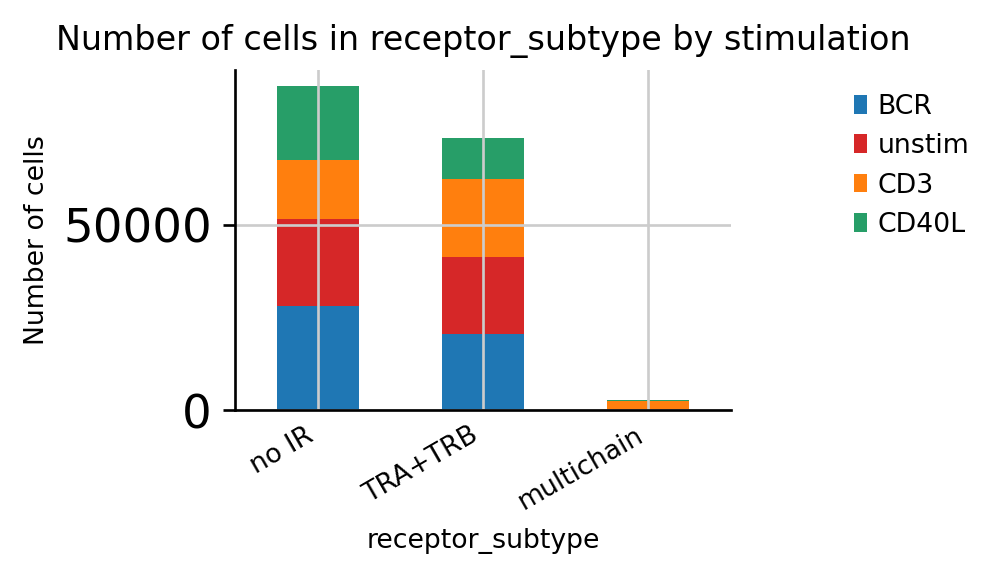

In [26]:
ir.pl.group_abundance(adata, groupby="receptor_subtype", target_col="stimulation")


<AxesSubplot:title={'center':'Number of cells in receptor_subtype by CVID_status'}, xlabel='receptor_subtype', ylabel='Number of cells'>

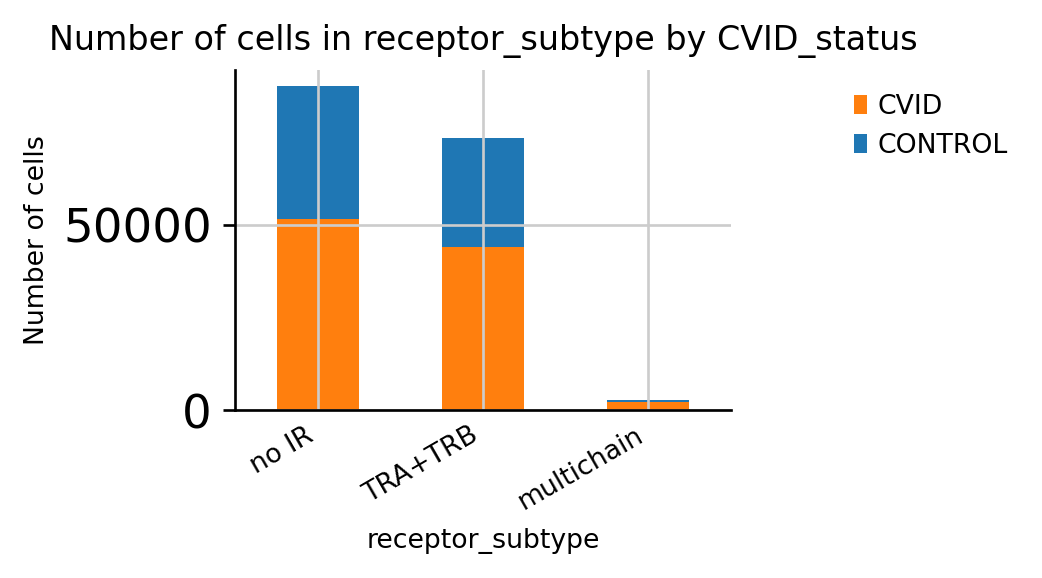

In [27]:
ir.pl.group_abundance(adata, groupby="receptor_subtype", target_col="CVID_status")


<AxesSubplot:title={'center':'Number of cells in receptor_subtype by donor'}, xlabel='receptor_subtype', ylabel='Number of cells'>

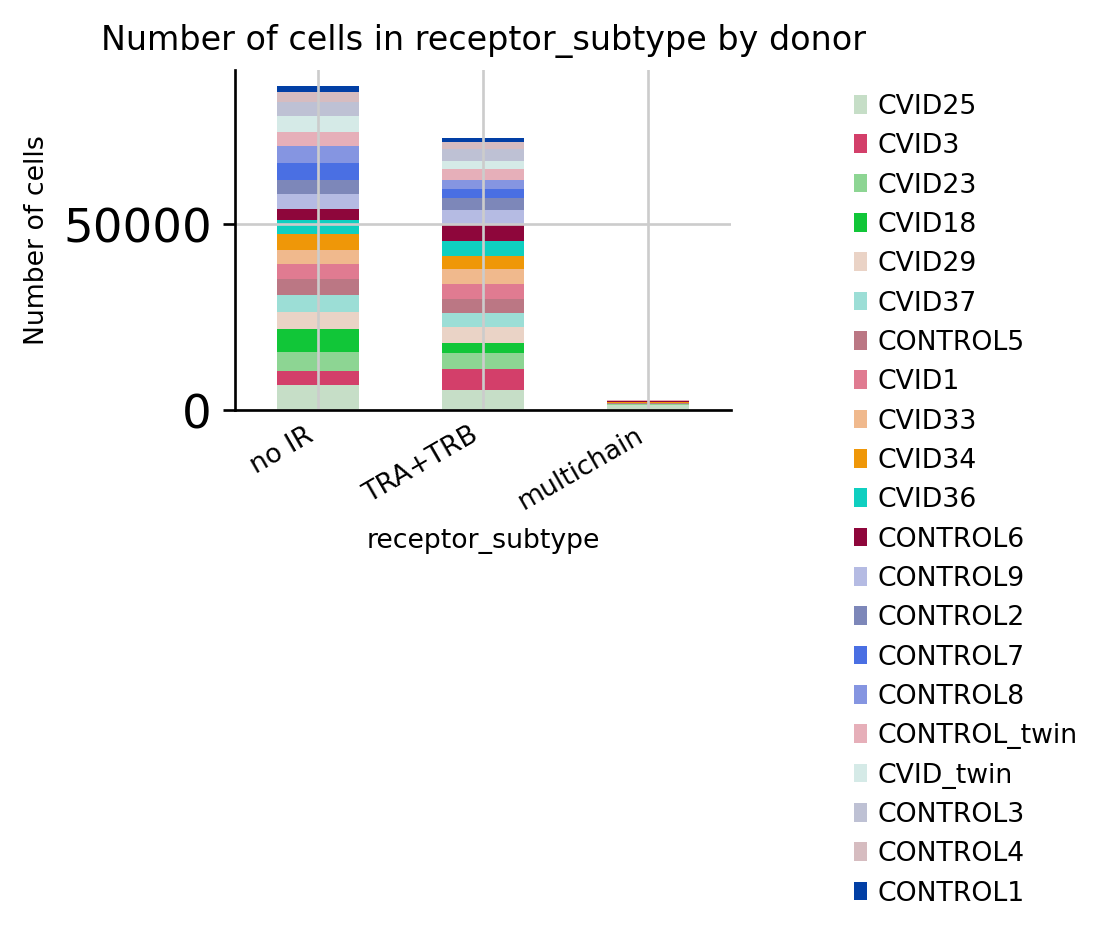

In [28]:
ir.pl.group_abundance(adata, groupby="receptor_subtype", target_col="donor")


In [29]:
adata

AnnData object with n_obs × n_vars = 163320 × 2734
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'donor_ID_temp', 'louvain', 'is_doublet_propagate', 'probabilities', 'celltype_predictions', 'louvain_R_16', 'louvain_R_24', 'louvain_R_0', 'louvain_R_9', 'louvain_R_1', 'prelim_annot', 'n_counts_protein', 'n_counts_protein_lognorm', 'donor', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr

In [30]:
adata.obs['louvain'] = adata.obs['louvain'].astype(str)

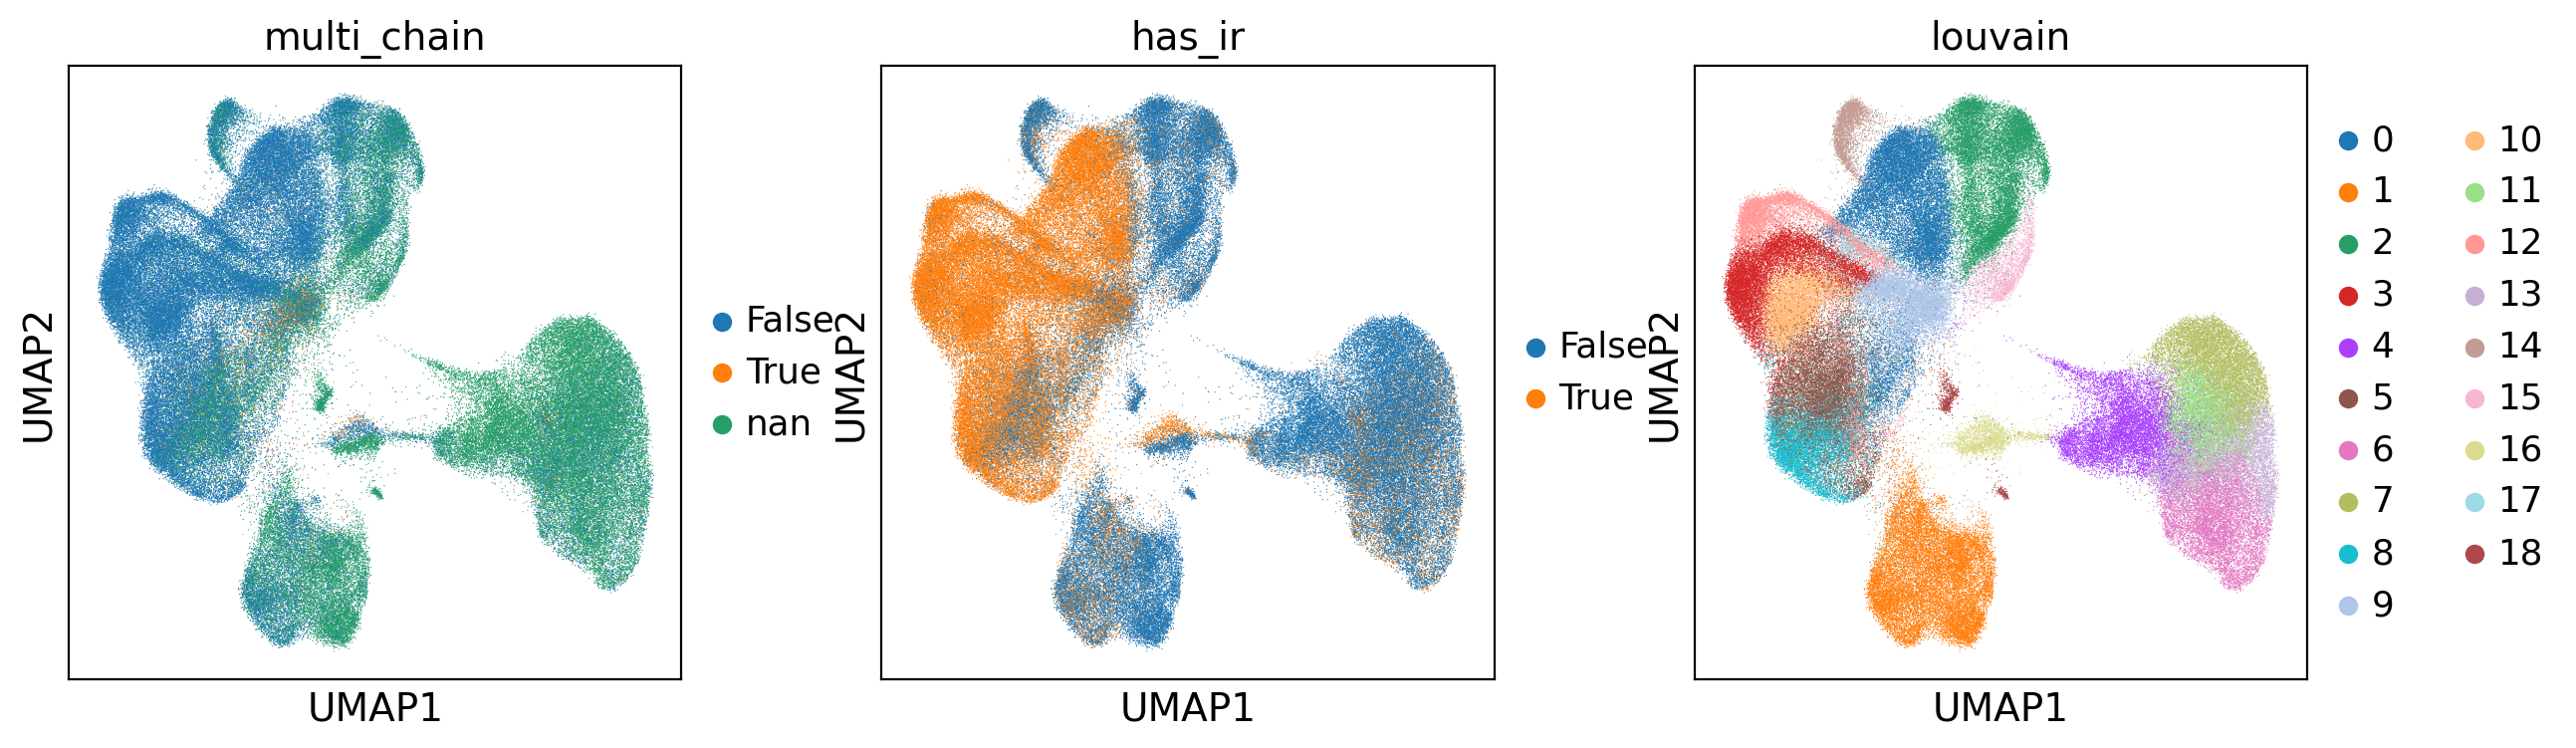

In [59]:
sc.pl.umap(adata, color=['multi_chain','has_ir','louvain'])


In [62]:
# reading preliminary annotation to know which cells are T cells
annot_table = pd.read_csv(save_path + 'annotation_of_adata_hvg_BBKNN_GEX_and_SoupX_denoised_protein_all_samples_20210108.csv',
                         index_col=0)

In [63]:
annot_table

cell_type
AAACCTGAGAATGTGT-1        Monocytes_CD16+
AAACCTGAGACTAAGT-1                   cDC2
AAACCTGAGCCGCCTA-1               TCM_CD8+
AAACCTGAGCGCCTCA-1               TEM_CD8+
AAACCTGAGGATGTAT-1               TEM_CD8+
...                                   ...
TTTGTCATCGCCTGAG-1    Monocytes_Classical
TTTGTCATCGTCACGG-1-1  Monocytes_Classical
TTTGTCATCGTCTGCT-1-1           iNKT_cells
TTTGTCATCTACTTAC-1               doublets
TTTGTCATCTCTTATG-1     T_cells_CD4+_naive

[163320 rows x 1 columns]

In [64]:
adata.obs['cell_type'] = annot_table.loc[adata.obs_names,'cell_type']

... storing 'cell_type' as categorical


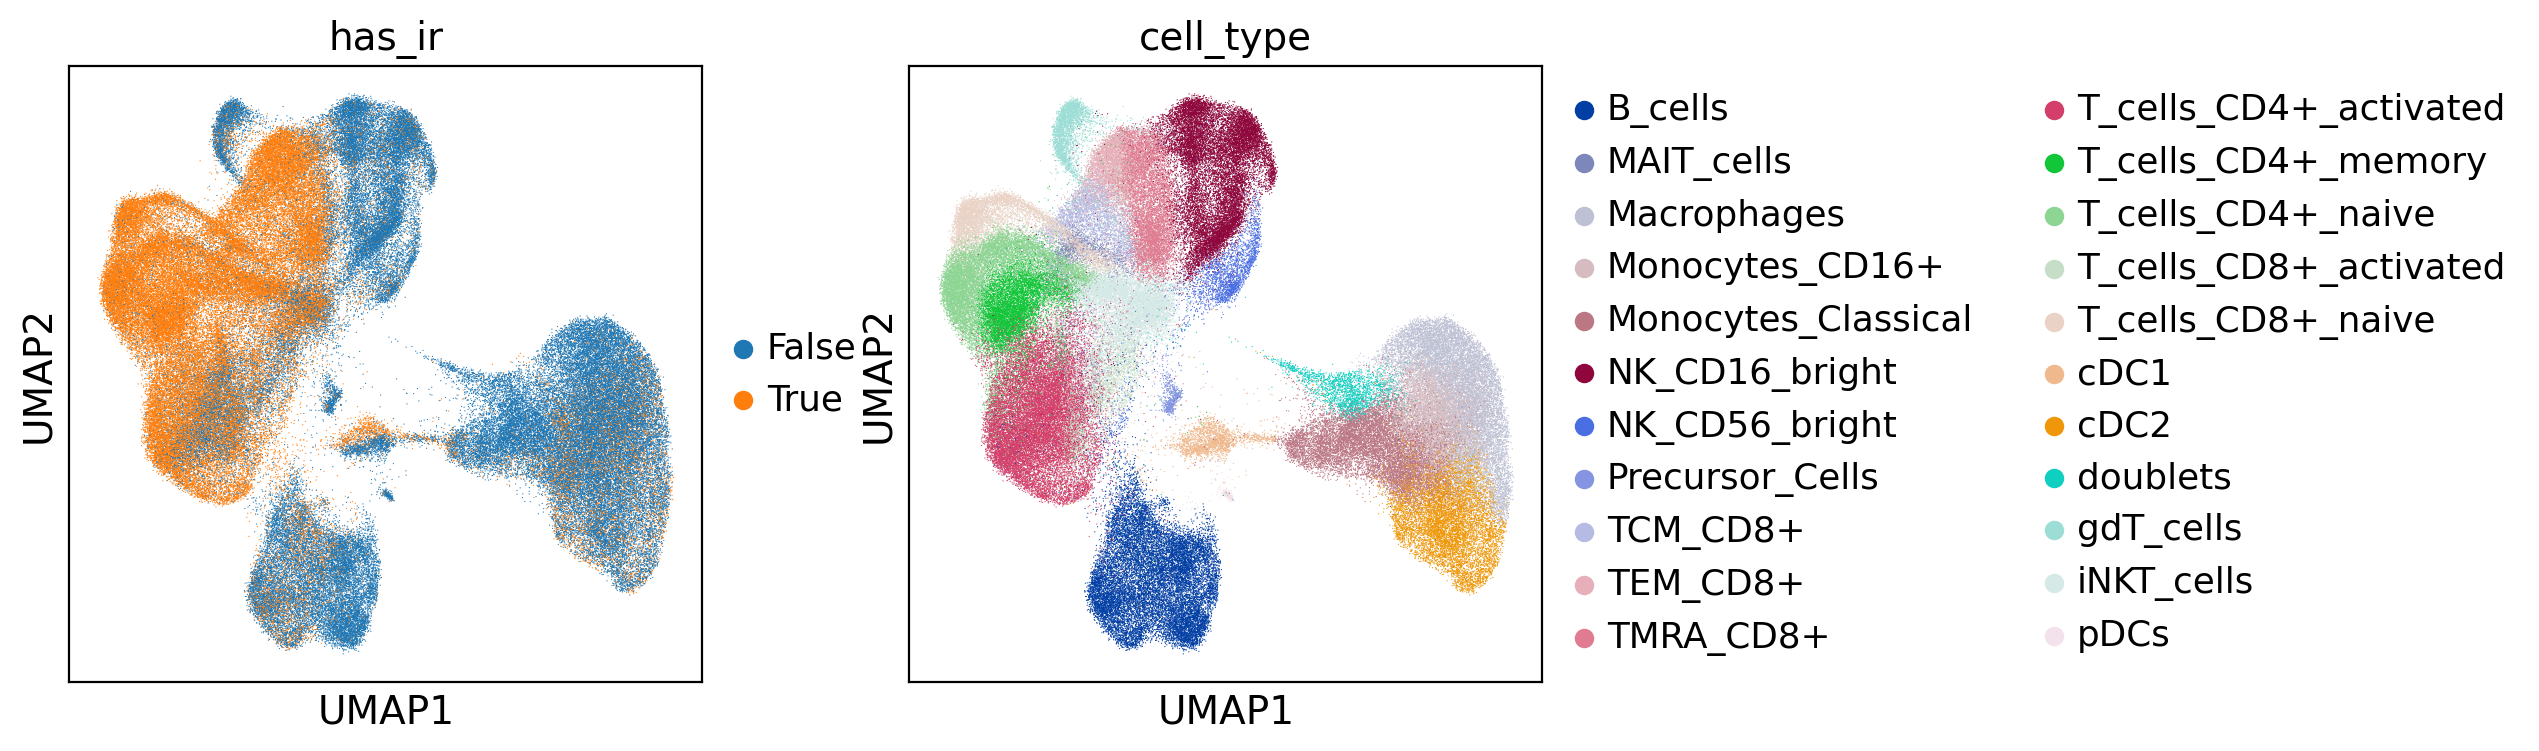

In [65]:
# any BCR data outside B cells (louvain cluster 1)?
sc.pl.umap(adata, color=['has_ir','cell_type'])


In [66]:
np.unique(adata.obs['has_ir'], return_counts=True)

(array(['False', 'True'], dtype=object), array([87261, 76059]))

In [67]:
np.unique(adata.obs['cell_type'], return_counts=True)

(array(['B_cells', 'MAIT_cells', 'Macrophages', 'Monocytes_CD16+',
        'Monocytes_Classical', 'NK_CD16_bright', 'NK_CD56_bright',
        'Precursor_Cells', 'TCM_CD8+', 'TEM_CD8+', 'TMRA_CD8+',
        'T_cells_CD4+_activated', 'T_cells_CD4+_memory',
        'T_cells_CD4+_naive', 'T_cells_CD8+_activated',
        'T_cells_CD8+_naive', 'cDC1', 'cDC2', 'doublets', 'gdT_cells',
        'iNKT_cells', 'pDCs'], dtype=object),
 array([18069,  2012, 12718,  7663, 11964, 16584,  2750,   661,  3613,
         4182,  8240, 19350,  8570, 11386,  4119,  5658,  2248,  9131,
         2126,  3358,  8706,   212]))

In [71]:
# marking cells with BCR information but not in cluster 1 (B cells) as 'doublets_by_BCR'
def mark_doublets_by_TCR(adata_obj, barcode):
    
    curr_cell_type = adata_obj.obs.loc[barcode, 'cell_type_prelim']
    
    # if the cell has BCR information
    has_tcr = adata_obj.obs.loc[barcode, 'has_ir']
    
    #print('louvain', curr_louvain)
    
    #print('has BCR info?', has_bcr, '\n')
    
    # is this a T cell?
    if curr_cell_type in ['MAIT_cells', 'TCM_CD8+', 'TEM_CD8+', 'TMRA_CD8+',
                          'T_cells_CD4+_activated', 'T_cells_CD4+_memory',
                          'T_cells_CD4+_naive', 'T_cells_CD8+_activated',
                          'T_cells_CD8+_naive', 'gdT_cells',
                          'iNKT_cells']:
        return('False')
    else:
        # does this non-T cell have TCR information?
        if has_tcr == 'True':
            return('True')
        else:
            return('False')

In [72]:
adata.obs['barcode']

AAACCTGAGAATGTGT-1        AAACCTGAGAATGTGT-1
AAACCTGAGACTAAGT-1        AAACCTGAGACTAAGT-1
AAACCTGAGCCGCCTA-1        AAACCTGAGCCGCCTA-1
AAACCTGAGCGCCTCA-1        AAACCTGAGCGCCTCA-1
AAACCTGAGGATGTAT-1        AAACCTGAGGATGTAT-1
                                ...         
TTTGTCATCGCCTGAG-1        TTTGTCATCGCCTGAG-1
TTTGTCATCGTCACGG-1-1    TTTGTCATCGTCACGG-1-1
TTTGTCATCGTCTGCT-1-1    TTTGTCATCGTCTGCT-1-1
TTTGTCATCTACTTAC-1        TTTGTCATCTACTTAC-1
TTTGTCATCTCTTATG-1        TTTGTCATCTCTTATG-1
Name: barcode, Length: 163320, dtype: object

In [73]:
adata.obs['doublets_by_TCR'] = adata.obs['barcode'].apply(lambda x: mark_doublets_by_TCR(adata,x))

In [74]:
np.unique(adata.obs['doublets_by_TCR'], return_counts=True)

(array(['False', 'True'], dtype=object), array([149897,  13423]))

... storing 'doublets_by_TCR' as categorical


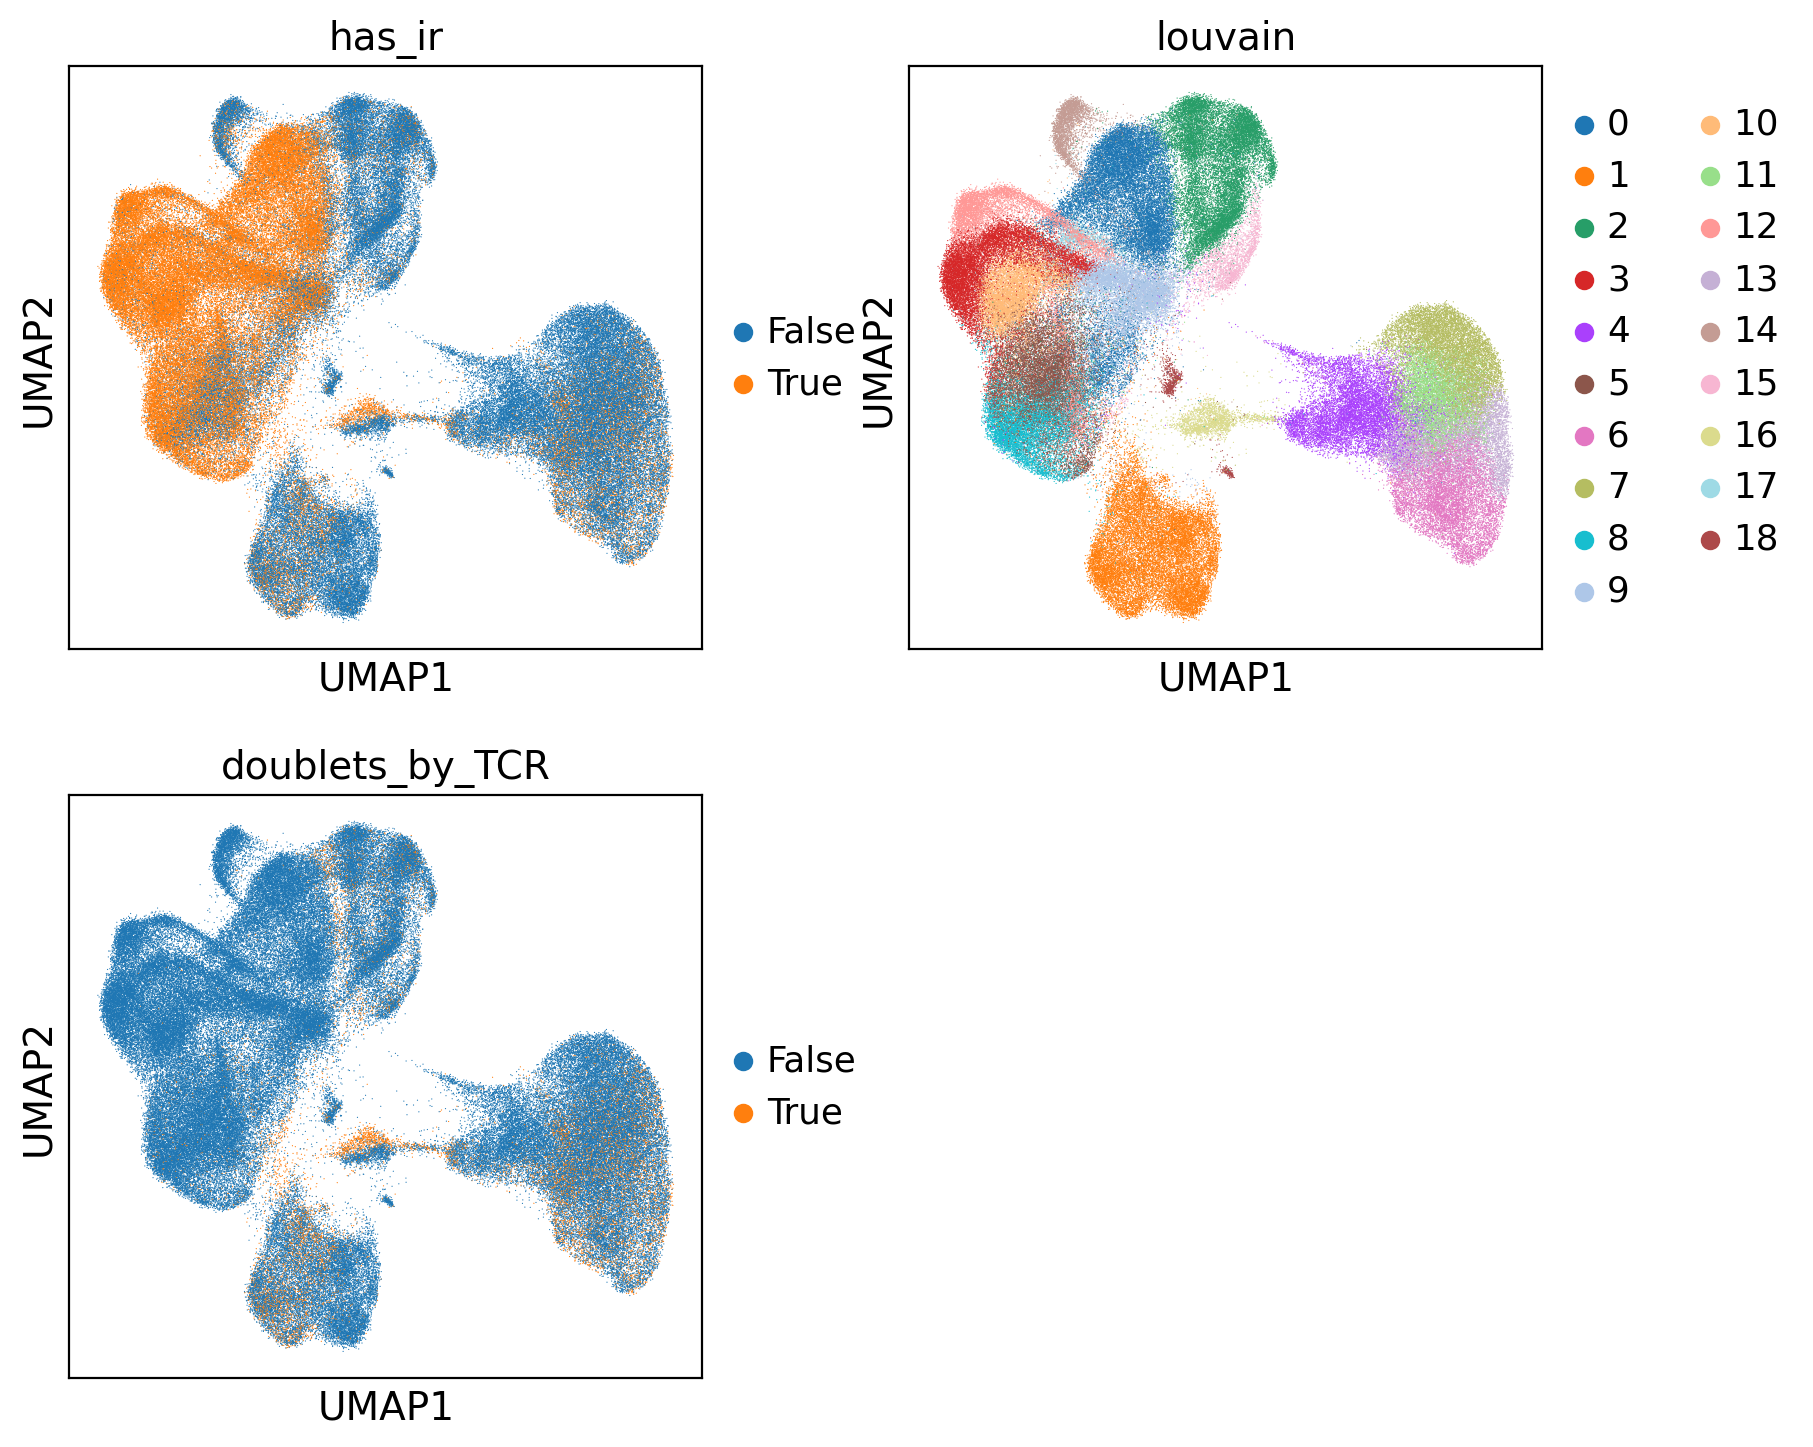

In [75]:
# any BCR data outside B cells (louvain cluster 1)?
sc.pl.umap(adata, color=['has_ir','louvain','doublets_by_TCR'], 
           cmap='OrRd', ncols=2)


In [76]:
adata.obs.loc[:,'doublets_by_TCR']

AAACCTGAGAATGTGT-1      False
AAACCTGAGACTAAGT-1      False
AAACCTGAGCCGCCTA-1      False
AAACCTGAGCGCCTCA-1      False
AAACCTGAGGATGTAT-1      False
                        ...  
TTTGTCATCGCCTGAG-1       True
TTTGTCATCGTCACGG-1-1    False
TTTGTCATCGTCTGCT-1-1    False
TTTGTCATCTACTTAC-1      False
TTTGTCATCTCTTATG-1      False
Name: doublets_by_TCR, Length: 163320, dtype: category
Categories (2, object): ['False', 'True']

In [77]:
doublets_by_TCR = pd.DataFrame(adata.obs.loc[:,'doublets_by_TCR'])

In [78]:
doublets_by_TCR

doublets_by_TCR
AAACCTGAGAATGTGT-1             False
AAACCTGAGACTAAGT-1             False
AAACCTGAGCCGCCTA-1             False
AAACCTGAGCGCCTCA-1             False
AAACCTGAGGATGTAT-1             False
...                              ...
TTTGTCATCGCCTGAG-1              True
TTTGTCATCGTCACGG-1-1           False
TTTGTCATCGTCTGCT-1-1           False
TTTGTCATCTACTTAC-1             False
TTTGTCATCTCTTATG-1             False

[163320 rows x 1 columns]

In [79]:
np.unique(doublets_by_TCR['doublets_by_TCR'], return_counts=True)

(array(['False', 'True'], dtype=object), array([149897,  13423]))

In [81]:
doublets_by_TCR.to_csv(save_path + 'doublets_by_TCR_table_20210106.csv')